In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
from tensorflow.keras.utils import plot_model
from time import time

In [2]:
trainset = pd.read_excel('traindata.xlsx', header = 0)
testset = pd.read_excel('testdata.xlsx', header = 0)

train_labels = trainset.iloc[:,-1]
test_labels = testset.iloc[:,-1]
train_data = trainset.iloc[:,0:-1]
test_data = testset.iloc[:,0:-1]

In [3]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [4]:
normal_train_data = normal_train_data.to_numpy()
normal_test_data = normal_test_data.to_numpy()
anomalous_train_data = anomalous_train_data.to_numpy()
anomalous_test_data = anomalous_test_data.to_numpy()

# VAE

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

def sampling_z(args):
  """Reparameterization trick by sampling from an isotropic unit Gaussian.
  
  # Arguments
      args (tensor): mean and log of variance of Q(z|X)

  # Returns
      z (tensor): sampled latent vector
  """
  
  z_mean, z_log_var = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]

  # by default, random_normal has mean = 0 and std = 1.0
  epsilon = K.random_normal(shape=(batch, dim))
  return z_mean + K.exp(0.5 * z_log_var) * epsilon      # basically creating the distribution of z, Q(z|X)

In [13]:

# network parameter
original_dim = 128

input_shape = (original_dim, )
intermediate_dim = [64, 32, 16, 8] 
batch_size = 100
latent_dim = 4
epochs = 100

In [14]:
# VAE model = encoder + decoder

# build encoder model: Q(z|X)
inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
x = tf.keras.layers.Dense(intermediate_dim[0], activation='tanh')(inputs)
x = tf.keras.layers.Dense(intermediate_dim[1], activation='relu')(x)
x = tf.keras.layers.Dense(intermediate_dim[2], activation='relu')(x)
x = tf.keras.layers.Dense(intermediate_dim[3], activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that 'output_shape' isn't necessary with the TensorFlow backend
z = tf.keras.layers.Lambda(sampling_z, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  # takes in z_mean, z_log_var and return z, using function sampling_z

# instantiate encoder model
encoder = tf.keras.Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

# build decoder model: P(X|z)
latent_inputs = tf.keras.Input(shape=(latent_dim, ), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim[3], activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(intermediate_dim[2], activation='relu')(x)
x = tf.keras.layers.Dense(intermediate_dim[1], activation='relu')(x)
x = tf.keras.layers.Dense(intermediate_dim[0], activation='relu')(x)

outputs = tf.keras.layers.Dense(original_dim, activation='relu')(x)

# instantiate decoder model
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')
vae.summary()
#plot_model(vae, to_file='vae_model.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           8256        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 32)           2080        dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           528         dense_8[0][0]                    
____________________________________________________________________________________________

In [15]:
from tensorflow.keras.losses import mse, binary_crossentropy

In [16]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

In [17]:
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
# kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# E[log P(X|z)]
# reconstruction_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=1)
vae_loss = 0.5*reconstruction_loss + 0.5*kl_loss
vae.add_loss(vae_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)
vae.compile(optimizer=optimizer)

In [18]:
start = time()
history = vae.fit(
    normal_train_data, normal_train_data,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_data, test_data)
)
end = time()

Epoch 1/100
166/166 [==============================] - 1s 4ms/step - loss: 4.0602 - val_loss: 2.8267
Epoch 2/100
166/166 [==============================] - 0s 3ms/step - loss: 2.7547 - val_loss: 2.8011
Epoch 3/100
166/166 [==============================] - 0s 2ms/step - loss: 2.7429 - val_loss: 2.7891
Epoch 4/100
166/166 [==============================] - 0s 2ms/step - loss: 2.7385 - val_loss: 2.7887
Epoch 5/100
166/166 [==============================] - 0s 3ms/step - loss: 2.7379 - val_loss: 2.7868
Epoch 6/100
166/166 [==============================] - 0s 2ms/step - loss: 2.7360 - val_loss: 2.7948
Epoch 7/100
166/166 [==============================] - 0s 2ms/step - loss: 2.7365 - val_loss: 2.7892
Epoch 8/100
166/166 [==============================] - 0s 2ms/step - loss: 2.7355 - val_loss: 2.7879
Epoch 9/100
166/166 [==============================] - 0s 2ms/step - loss: 2.7364 - val_loss: 2.7954
Epoch 10/100
166/166 [==============================] - 0s 3ms/step - loss: 2.7350 - val_lo

166/166 [==============================] - 0s 2ms/step - loss: 2.1633 - val_loss: 2.2144
Epoch 82/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1630 - val_loss: 2.2145
Epoch 83/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1638 - val_loss: 2.2154
Epoch 84/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1629 - val_loss: 2.2160
Epoch 85/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1627 - val_loss: 2.2144
Epoch 86/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1633 - val_loss: 2.2192
Epoch 87/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1631 - val_loss: 2.2165
Epoch 88/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1629 - val_loss: 2.2140
Epoch 89/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1628 - val_loss: 2.2152
Epoch 90/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1632 - val_loss: 

In [19]:
end - start

35.22221302986145

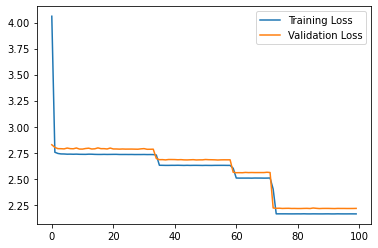

In [20]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


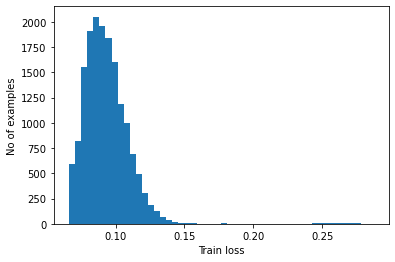

In [21]:
reconstructions = vae.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [31]:
test_data = test_data.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [50]:
threshold = 0.3 #np.mean(train_loss) + 1*np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.3


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [52]:
preds = predict(vae, test_data, threshold)
print_stats(preds, test_labels)


Accuracy = 0.7147217982516998
Precision = 0.7147217982516998
Recall = 1.0


# SHAP

In [126]:
train = pd.DataFrame(normal_train_data)
test = pd.DataFrame(test_data)


In [126]:
train = pd.DataFrame(normal_train_data)
test = pd.DataFrame(test_data)


In [128]:
import shap
from tensorflow.keras.layers import Input
shap.initjs()

shap_explainer = shap.KernelExplainer(vae,train[0:1000])
shap_values = shap_explainer.shap_values(test[0:1000])

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


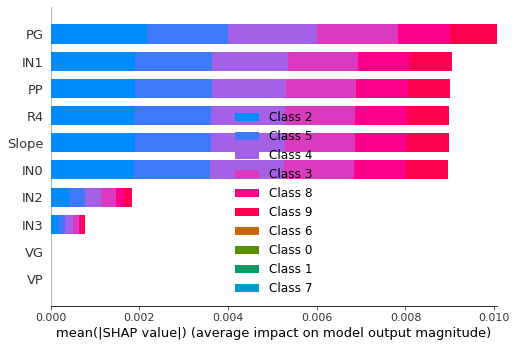

In [129]:
shap.summary_plot(shap_values, data.values, plot_type="bar", feature_names = data.columns)

In [130]:
shap.force_plot(shap_explainer.expected_value[3], shap_values[3],feature_names = data.columns)

In [131]:
shap.force_plot(shap_explainer.expected_value[3], shap_values[3][0], data.iloc[3, :])

In [132]:
shap_explainer.expected_value

array([0.        , 0.        , 0.78030073, 0.92613331, 0.61570161,
       0.94474833, 0.        , 0.        , 0.58353422, 0.41167071])

In [133]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.00000000e+00,  2.02980081e-03,  7.68643038e-04, ...,
          0.00000000e+00,  5.38410713e-04,  7.54785724e-04],
        [ 0.00000000e+00,  0.00000000e+00, -3.53130729e-04, ...,
          0.00000000e+00, -4.57425204e-04, -6.12075208e-04],
        [ 0.00000000e+00,  0.00000000e+00, -4.20986819e-03, ...,
          0.00000000e+00, -4.10392555e-03, -3.93982790e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00, -2.91070621e-03, ...,
          0.00000000e+00, -3.12395221e-03, -3.

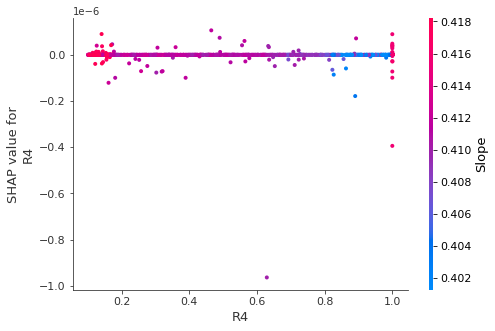

In [134]:
shap.dependence_plot(8, shap_values[0], train[0:1000].values, feature_names=data.columns)